In [128]:
import nltk
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# 요약: 뉴스

In [129]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(len(data))
data.head()

98401


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 데이터 전처리하기

In [130]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


Text가 달라도 Summary는 동일 할 수있다. 하지만 Text 자체가 겹치는 경우는 없애야 한다.

In [131]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [132]:
# 결측치 제거
print(data.isnull().sum())
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


### 텍스트 정규화 및 불용어 제거

연산량을 줄이기 위하여 ex) it'll 과 it will은 같은 표현이기 때문에 하나의 표현으로 통일시켜 준다. 이러한 방법론을 텍스트처리에서는 Text normalization이라고 한다.  
[정규화 사전 출처](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)

In [133]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


텍스트에는 자주 등장하지만 자연어 처리를 할 때 별 도움이 안되는 단어들이 있는데 이를 Stopword라고 한다. Stopword를 제거하는 것이 자연어 처리의 성능을 높히는 방법일 수 있다.  
 NLTK에서 제공하는 불용어 리스트를 참조하여 불용어 제거

In [134]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [135]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [136]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

C:\Users\User\AppData\Local\Temp\ipykernel_2984\966821911.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거


Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [137]:
print(data.isnull().sum())
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553660024400163


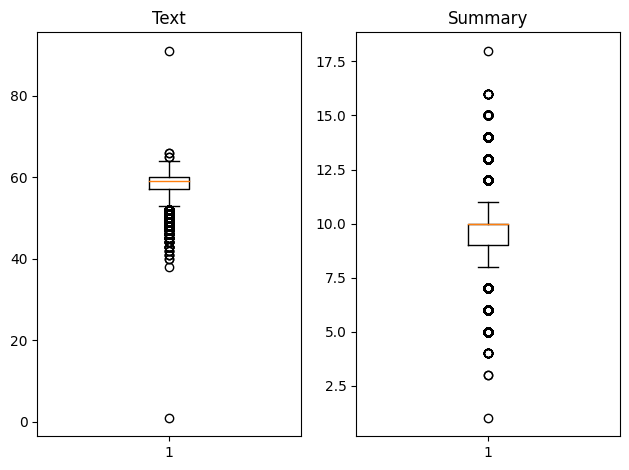

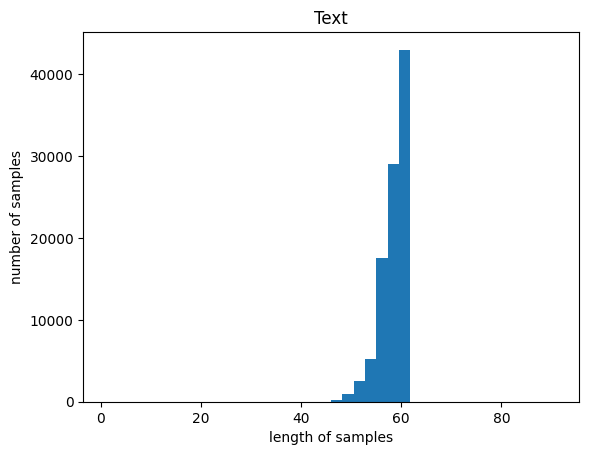

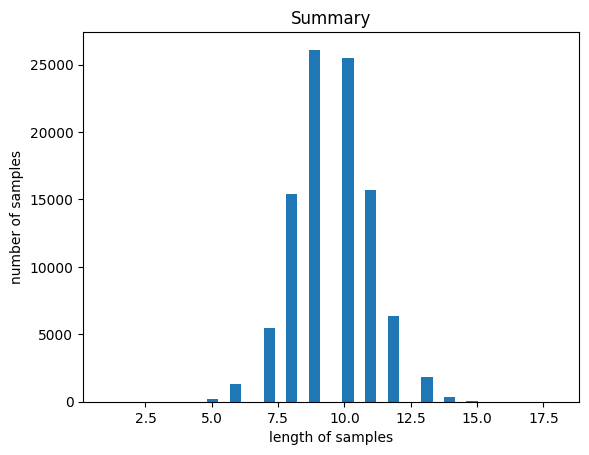

In [138]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [139]:
text_max_len = 91
summary_max_len = 18

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 91 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 18 이하인 샘플의 비율: 1.0


정해진 길이보다 길면 제외한다.

In [140]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 시작, 종료 토큰 추가하기

In [141]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",sostoken upGrad learner switches to career in ...,upGrad learner switches to career in ML & Al w...
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...,"sostoken Have known Hirani for yrs, what if Me...","Have known Hirani for yrs, what if MeToo claim..."


In [142]:
# Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [143]:
from sklearn.model_selection import train_test_split

# 데이터 분할
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(encoder_input, decoder_input, decoder_target,
                                                                                                                                               random_state=42,
                                                                                                                                               test_size=0.2)
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### 단어집합(vocabulary) 만들기 및 정수 인코딩

단어를 매핑하기 위해 단어집합이 필요하다

In [144]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
src_tokenizer.word_index

{'the': 1,
 'to': 2,
 'a': 3,
 'in': 4,
 'of': 5,
 'and': 6,
 'on': 7,
 'has': 8,
 'for': 9,
 'said': 10,
 'that': 11,
 'was': 12,
 'is': 13,
 'he': 14,
 'by': 15,
 'with': 16,
 'his': 17,
 'after': 18,
 'from': 19,
 'as': 20,
 'it': 21,
 'at': 22,
 'will': 23,
 'an': 24,
 'be': 25,
 'have': 26,
 'had': 27,
 'who': 28,
 'added': 29,
 'year': 30,
 'which': 31,
 'her': 32,
 'been': 33,
 'were': 34,
 'this': 35,
 'over': 36,
 'its': 37,
 'not': 38,
 'india': 39,
 'also': 40,
 'us': 41,
 'she': 42,
 'i': 43,
 'are': 44,
 'their': 45,
 'while': 46,
 'against': 47,
 'first': 48,
 'police': 49,
 'people': 50,
 'about': 51,
 'government': 52,
 'indian': 53,
 'old': 54,
 'two': 55,
 'they': 56,
 'crore': 57,
 'minister': 58,
 'film': 59,
 'president': 60,
 'him': 61,
 'one': 62,
 'further': 63,
 'during': 64,
 'up': 65,
 'court': 66,
 '000': 67,
 'when': 68,
 'all': 69,
 'years': 70,
 'reportedly': 71,
 'out': 72,
 'state': 73,
 'new': 74,
 'being': 75,
 'time': 76,
 'former': 77,
 'would': 78,

빈도가 낮은 단어 확인

In [145]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 91208
등장 빈도가 6번 이하인 희귀 단어의 수: 66475
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24733
단어 집합에서 희귀 단어의 비율: 72.88286115253048
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.7278625414665254


* 3만여개의 단어중 빈도수가 적은 희귀 단어가 차지하는 비율이 75%나 된다.하지만 전체에서 1.8%  
* 따라서 희귀 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거한다.  
* 토크나이저 정의 시 num_words 값을 정해주면 단어집합 크기 제한 가능.

In [146]:
src_vocab = 24000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 24733으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [147]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2531, 478, 58, 7249, 7698, 7, 134, 3227, 253, 671, 162, 1151, 1543, 559, 3, 1968, 232, 14, 184, 6068, 2712, 954, 4, 21, 7698, 762, 1151, 1543, 559, 64, 17, 504, 2, 13584, 199, 1, 55, 601, 3517, 3456, 671, 1894, 6, 1175, 14501, 5, 2832, 7, 1, 671, 3961, 35, 122, 509, 5, 1151, 1543, 6069, 480, 16, 41, 60, 206, 136], [49, 892, 4, 9053, 399, 26, 456, 16799, 4, 4307, 8233, 6, 1066, 50, 47, 10808, 3497, 89, 4702, 28, 4226, 6387, 6, 581, 9, 276, 9053, 8, 3, 1389, 53, 1825, 1857, 2596, 2807, 15, 3497, 193, 5, 2353, 44, 6, 28, 44, 1665, 2, 1529, 1263, 4346, 1, 49, 10], [1121, 336, 250, 74, 239, 19, 8496, 2759, 26, 10599, 1, 5079, 5, 3, 101, 7, 1730, 628, 8497, 20, 132, 375, 1398, 634, 6, 1815, 1406, 10196, 2935, 1, 4463, 6388, 425, 1, 5578, 31, 3751, 2, 14023, 425, 8497, 2284, 1, 239, 12, 4250, 15, 6970, 3, 5194, 4, 22999, 6, 2, 3209, 1, 6735]]


Summary에 대해서도 같은 작업 수행

In [148]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [149]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40682
등장 빈도가 6번 이하인 희귀 단어의 수: 30428
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10254
단어 집합에서 희귀 단어의 비율: 74.79474952067253
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.859113807098137


단어집합에서 78%정도 차지하지만 전체에서 6.1%등장 위와 마찬가지로 제거.

In [150]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 168, 1668, 380, 2956, 736, 1094, 195, 9, 5], [1, 102, 68, 4767, 6, 5087, 4, 7240, 3173], [1, 339, 6, 140, 4086, 66, 671, 84, 4768], [1, 50, 3753, 3970, 8166, 7, 3754, 34, 189, 3, 1021], [1, 575, 1022, 710, 1942, 3094, 3, 1943, 24]]
target
decoder  [[168, 1668, 380, 2956, 736, 1094, 195, 9, 5, 2], [102, 68, 4767, 6, 5087, 4, 7240, 3173, 2], [339, 6, 140, 4086, 66, 671, 84, 4768, 2], [50, 3753, 3970, 8166, 7, 3754, 34, 189, 3, 1021, 2], [575, 1022, 710, 1942, 3094, 3, 1943, 24, 2]]


빈도수 낮은 단어를 삭제했으므로 다시한번 값이 없는 샘플이 있는지 확인한다.  


In [151]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78687
훈련 레이블의 개수 : 78687
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### 패딩하기

In [152]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 모델 설계

In [153]:
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, TimeDistributed, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계용
embedding_dim = 512
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)


encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5, name='lstm1', kernel_initializer='glorot_normal')
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5, name='lstm2', kernel_initializer='glorot_normal')
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5, name='lstm3', kernel_initializer='glorot_normal')
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output2)

In [154]:
# 디코더 설계
decoder_inputs = Input(shape=(None, ))
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [155]:
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import plot_model

# Attention layer 추가
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 레이어에 전달하고 결과 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

#모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 91)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 91, 512)      12288000    input_18[0][0]                   
__________________________________________________________________________________________________
lstm1 (LSTM)                    [(None, 91, 256), (N 787456      embedding_8[0][0]                
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

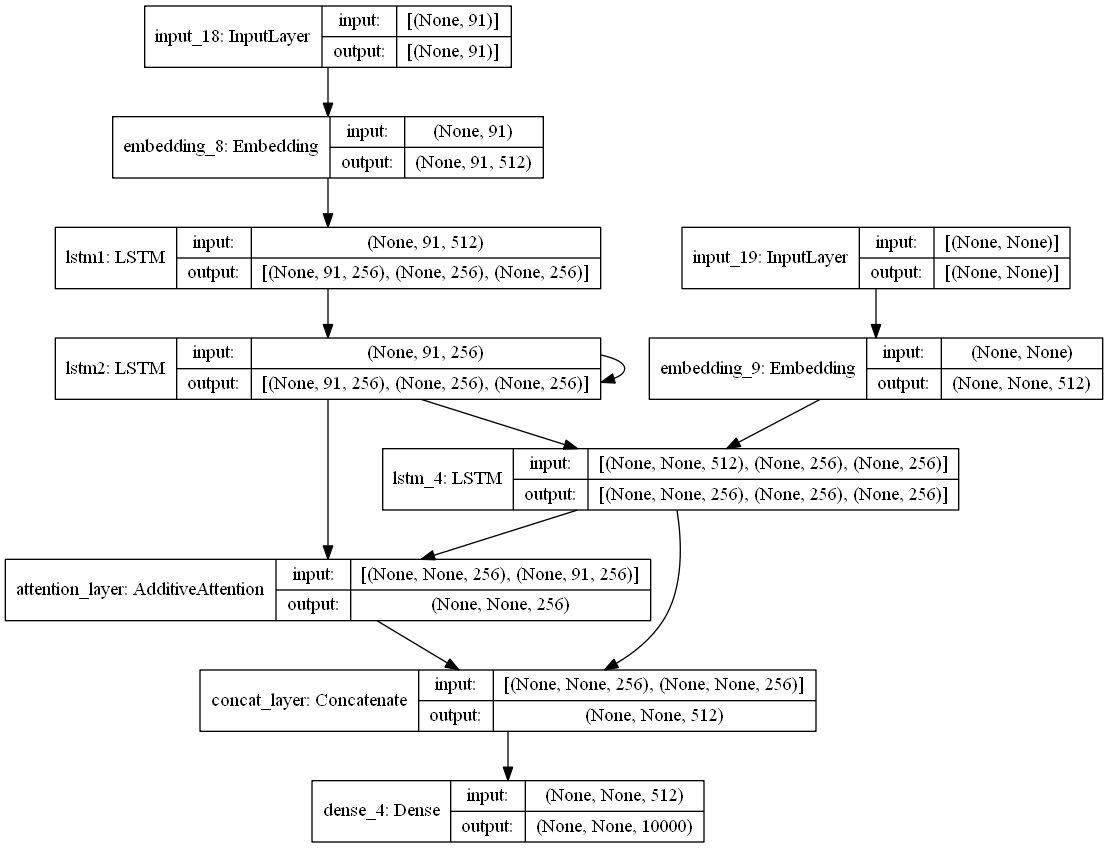

In [156]:
plot_model(model, show_shapes=True)

## 모델 훈련

In [157]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 18s 47ms/step - loss: 3.9372 - val_loss: 3.5585
Epoch 2/50
308/308 [==============================] - 14s 45ms/step - loss: 3.4269 - val_loss: 3.2295
Epoch 3/50
308/308 [==============================] - 14s 45ms/step - loss: 3.1271 - val_loss: 3.0119
Epoch 4/50
308/308 [==============================] - 14s 45ms/step - loss: 2.9288 - val_loss: 2.8820
Epoch 5/50
308/308 [==============================] - 14s 45ms/step - loss: 2.7785 - val_loss: 2.7843
Epoch 6/50
308/308 [==============================] - 14s 45ms/step - loss: 2.6566 - val_loss: 2.7162
Epoch 7/50
308/308 [==============================] - 14s 45ms/step - loss: 2.5536 - val_loss: 2.6648
Epoch 8/50
308/308 [==============================] - 14s 45ms/step - loss: 2.4645 - val_loss: 2.6143
Epoch 9/50
308/308 [==============================] - 14s 45ms/step - loss: 2.3844 - val_loss: 2.5807
Epoch 10/50
308/308 [==============================] - 14s 45ms/step - loss: 2.313

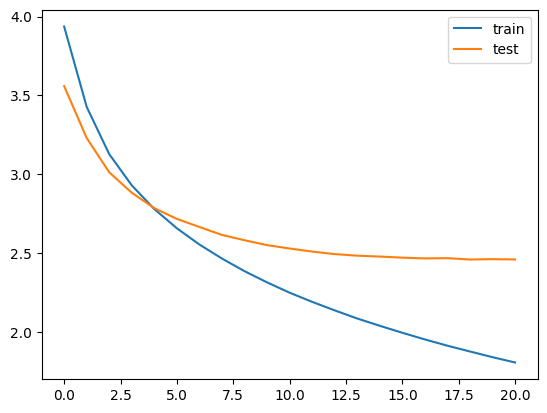

In [158]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Inference 모델 구현

In [159]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

train step에서는 디코더의 입력부에 정답 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있지만,  
inference step에서는 정답 문장이 없이 만들어야 할 문장의 길이만큼 디코더가 반복구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다. 이때 인코더와 디코더 모델을 분리한다

In [160]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))
dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h, state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_c, decoder_state_input_h])

In [161]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

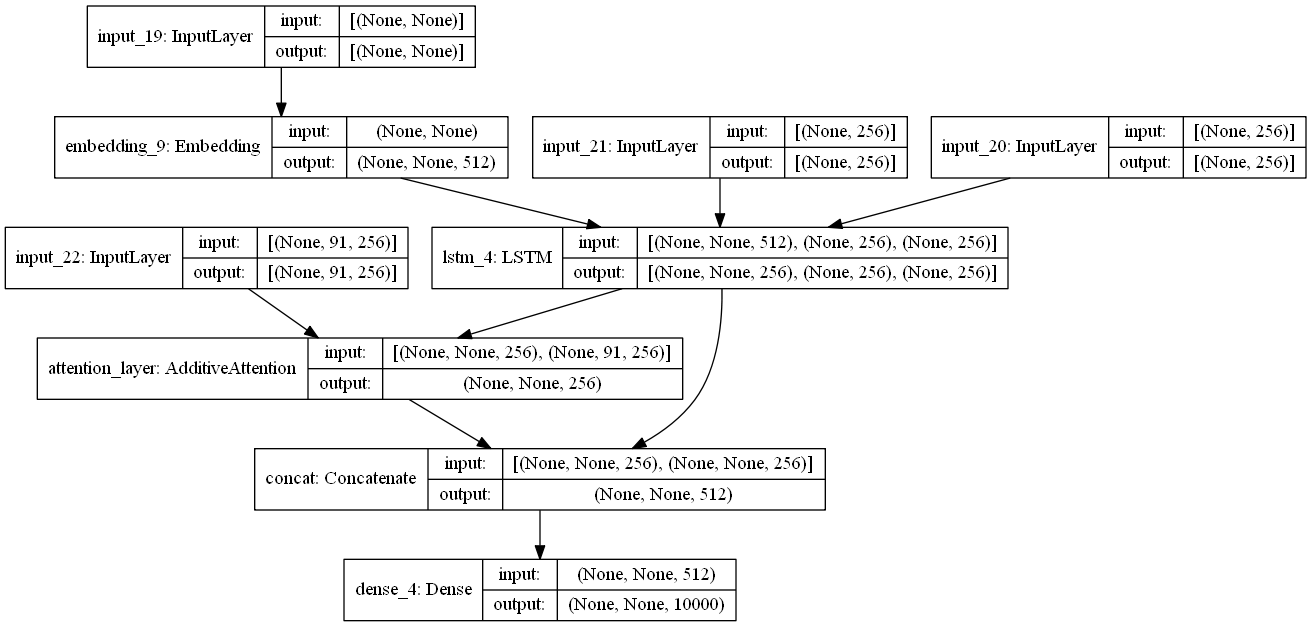

In [162]:
plot_model(decoder_model, show_shapes=True)

In [163]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트

In [164]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [165]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : tony the french referee who kicked out at a footballer before sending him off during a ligue 1 game was handed a three month ban with a further three months suspended ban by the ligue 1 had apologised for his actions the following day of the incident and called his own reaction and inappropriate 
실제 요약 : french referee who kicked footballer banned for 3 months 
예측 요약 :  italian referee referee


원문 : after priyanka gandhi vadra entered active politics sad chief sukhbir singh badal said i think they are training her so that when congress president rahul gandhi will fail they can bring in priyanka gandhi he added this is all drama and their media strategy it will not make any difference at ground level 
실제 요약 : congress training priyanka to take over when rahul fails sad 
예측 요약 :  priyanka hope priyanka


원문 : on the occasion of his country's independence day pakistani pm shahid abbasi on monday urged the international community to play its due role in resolving the kashmir issue wi

## 추출적 요약과 비교

In [166]:
import requests
from summa.summarizer import summarize

In [167]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print(len(data))

98401


In [171]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print('추출적 요약:',summarize(data['text'].iloc[i], ratio=0.3 ,words=summary_max_len))
    print("\n")


원문 : tony the french referee who kicked out at a footballer before sending him off during a ligue 1 game was handed a three month ban with a further three months suspended ban by the ligue 1 had apologised for his actions the following day of the incident and called his own reaction and inappropriate 
실제 요약 : french referee who kicked footballer banned for 3 months 
예측 요약 :  italian referee referee
추출적 요약: Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : after priyanka gandhi vadra entered active politics sad chief sukhbir singh badal said i think they are training her so that when congress president rahul gandhi will fail they can bring in priyanka gandhi he added this is all drama and their media strategy it will not make any difference at ground level 
실제 요약 : congress training priyanka to take over when rahul fails sad 
예측 요약 :  priyanka hope priyanka
추출적 요약: Boein

추출적 요약이 추상적 요약보다 더욱 잘 되었다. 추상적 요약의 임베딩 층을 gensim으로 바꿔주는 방법으로 성능을 높히는 시도를 할 수 있을 것 같다.